# Data Analysis

This notebook is devoted to the analysis of the DWAVE data and the comparison between them and the data generated by the Neural Network (MADE for the moment) 

In [6]:
import glob
from typing import Sequence, List, Optional

from math import sqrt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from numba import jit
from tqdm import tqdm

#from src.utils.smart_montecarlo import mcmc
from src.utils.montecarlo import neural_mcmc
from src.utils.adjacency import Adjacency
from src.utils.utils import compute_energy


In [7]:
@jit(nopython=True)
def econf(Lx: int, J: np.ndarray, S0: np.ndarray) -> float:
    energy = 0.
    for kx in range(Lx):
        for ky in range(Lx):

            k = kx + (Lx * ky)
            R = kx + 1  # right spin
            D = ky + 1  # down spin

            kR = k - ky  # coupling to the right of S0[kx,ky]
            kD = k  # coupling to the down of S0[kx,ky]

            # Tries to find a spin to right, if no spin, contribution is 0.
            Rs = S0[R, ky] * J[kR, 0] if R % Lx != 0 else 0
            # Tries to find a spin to left, if no spin, contribution is 0.
            Ds = S0[kx, D] * J[kD, 1] if D % Lx != 0 else 0

            energy += -S0[kx, ky] * (Rs + Ds)
    return energy / (Lx**2)


In [8]:
def get_coupling_open(Lx: int = 22, seed: int = 12345):
    np.random.seed(seed)
    N=Lx**2
    return (np.random.normal(0.0, 1.0, size=(N - Lx, 2)))

In [9]:
def plot_hist(gen_paths: Sequence[str], couplings_path: str, truth_path: str = "/home/scriva/pixel-cnn/data/100-v1/train_100_lattice_2d_ising_spins.npy", seed: int = 12345, labels: Optional[List[str]] = None, save: bool = False) -> None:
    if labels is None:
        labels = [f"eng{i}" for i, _ in enumerate(gen_paths)]

    truth = np.load(truth_path)
    
    try:
        truth = truth["sample"]
    except:
        print(f"No sample subdir found in {truth_path} \nLoading from path...")
        truth = truth

    #truth = np.reshape(truth, (-1, int(sqrt(truth.shape[-1])), int(sqrt(truth.shape[-1]))), order='F')
    max_len_sample = truth.shape[0]
    truth = np.reshape(truth, (max_len_sample, -1))
    square_spin = int(np.sqrt(truth.shape[-1]))

    adjacency = Adjacency(square_spin)
    adjacency.loadtxt(couplings_path)
    # get neighbourhood and couplings matrix
    neighbours, couplings = adjacency.get_neighbours()
    neighbours = neighbours.astype(int)
    len_neighbours = np.sum(couplings != 0, axis=-1) # (square_spin, seed=seed)

    eng_truth = []
    for t in truth:
        eng_truth.append(compute_energy(t, neighbours, couplings, len_neighbours))
    eng_truth = np.asarray(eng_truth) / square_spin**2

    min_eng, max_eng = eng_truth.min(), eng_truth.max()
    
    engs= []
    for path in gen_paths:
        out = np.load(path)

        try:
            sample = out["sample"]
        except:
            print(f"No sample subdir found in {path} \nLoading from path...")
            sample = out
        
        sample = sample.squeeze()
        max_len_sample = min(max_len_sample, sample.shape[0])
        sample = np.reshape(sample, (-1, square_spin, square_spin), order='F')
        sample = np.reshape(sample, (-1, square_spin**2), order='F')
        #sample = np.reshape(sample, (-1, square_spin, square_spin), order='F')

        eng = []
        for s in sample:
            eng.append(compute_energy(s, neighbours, couplings, len_neighbours))
        eng = np.asarray(eng) / square_spin**2

        min_eng = min(min_eng, eng.min())
        max_eng = max(max_eng, eng.max())
        engs.append(eng)

    fig, ax = plt.subplots(figsize=(8,8), facecolor='white')
    
    plt.rcParams['mathtext.fontset']= "stix"
    plt.rcParams['font.family']= 'STIXGeneral'
    plt.rcParams['axes.linewidth'] = 1.5

    stringfont = 'serif'

    ax.tick_params(axis='y',labelsize=18)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(which='both', top=True, right=True, direction='in')
    
    bins = np.linspace(min_eng, max_eng).tolist()

    color=['mediumblue','darkorange']
    for i, eng in enumerate(engs):
        _ = plt.hist(eng, bins=bins, log=True, label=f"{labels[i]}", histtype='bar', color=[color[i]], alpha=0.7-i*0.1)
        print(f"\neng {i}\nmean: {eng.mean()}\nmin: {eng.min()} ({np.sum(eng==eng.min())} time(s))")
    _ = plt.hist(eng_truth, bins=bins, log=True, label=r"DWAVE 100$\mu$s", histtype='bar', edgecolor='k', color=['lightgrey'], alpha=0.6)
    
    print(f"\nDWave data eng\nmean: {eng_truth.mean()}\nmin: {eng_truth.min()}  ({np.sum(eng_truth==eng_truth.min())} time(s))")

    plt.ylabel("Count", fontsize=26, fontfamily=stringfont)
    plt.xlabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont)

    plt.ylim(1, max_len_sample*0.5)
    plt.legend(loc='best', labelspacing=0.4, fontsize=18, borderpad=0.2)

    if save:
        plt.savefig("hist.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

    return engs, eng_truth

## Check energy

Load dataset as it is saved by [DWAVE system](https://cloud.dwavesys.com/leap/login/?next=/leap/). Since there is a maximum time for the annealing process, data are saved in files with maximum size of 10k sample. In the same folder one can find also two energy file, one computed directly by DWAVE annealer and the other one with our custom algorithm. Both should give us the same result. So, here we load the dataset and we rearrange them in two files, namely train and validation dataset.

In [3]:
files = glob.glob(f'temp-data/test/*.npy')
print(files)

# arrs = []
# for file in files:
#     arrs.append(np.load(file))
#     print(np.isfortran(np.load(file)))
#     arrs[-1] = arrs[-1].reshape((-1, 484), order='F')
#     arrs[-1] = arrs[-1].reshape((-1, 22, 22))
#     print(arrs[-1].shape)
# dataset = np.concatenate(arrs, axis=0)

dataset = np.load("data/datasets/484-1nn-100mu/DWAVE-train-484spins-1nn-100mu.npy")[:-85000]
dataset = np.append(dataset, np.load("data/datasets/484-1nn-100mu/DWAVE-test-484spins-1nn-100mu.npy")[:-15000], axis=0)
dataset = np.append(dataset, np.load("data/484spins-seed12345-sample100000-beta1.8.npy"), axis=0)

print(dataset.shape)
#np.save("100spins-1nn-ssf", dataset)
train_data, test_data = train_test_split(dataset, test_size=0.15)

print(train_data.shape, test_data.shape)
# Comment off the following lines to save the datasets.
np.save('train-484-1nn-100mus-beta18', train_data)
np.save('test-484-1nn-100mus-beta18', test_data)
#np.save("1000mu", dataset)

[]
(400000, 484)
(340000, 484) (60000, 484)


In [37]:
a = np.load("data/datasets/484-3nn-10mu/DWAVE-train-484spins-3nn-10mu.npy")
a = np.reshape(a, (a.shape[0], -1), order='F')
a = np.reshape(a, (a.shape[0], 22, 22), order='C')

np.save("data/datasets/484-3nn-10mu/DWAVE-train-484spins-3nn-10mu-new.npy", a)

In [24]:
a = np.arange(9).reshape((3,3), order='F')
b = np.arange(9).reshape((3,3), order='F')

c = []
c.append(a)
c.append(b)
c = np.asarray((c))
print(c, c.shape)
c = c.reshape((2, -1), order='F')
c.reshape((2, 3, 3))

[[[0 3 6]
  [1 4 7]
  [2 5 8]]

 [[0 3 6]
  [1 4 7]
  [2 5 8]]] (2, 3, 3)


array([[[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]],

       [[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]])

Here we load a small part of the original dataset in order to check if the energy is well computed.

In [ ]:
sample = np.load("../data/1-50k_open-simple_10mu/configs_0.npy")
dwave_eng = np.load("../data/1-50k_open-simple_10mu/dwave-engs_0.npy")
eng = np.loadtxt("../data/1-50k_open-simple_10mu/energies_0.txt")

print(f"Energy (from DWAVE) {dwave_eng[:4]}\nEnergy (our algo) {-eng[:4]*484}")

## Plot histograms

Here we want to check if the Neural Network has been well trained, a good measure could also be the mean energy of the DWAVE data and the generated data.

No sample subdir found in data/datasets/seq_temp/100spins_open-1nn/dataset-beta2.0.npy 
Loading from path...
No sample subdir found in 100spins-seed12345-sample100000-beta0.5.npy 
Loading from path...

eng 0
mean: -0.7490173627741954
min: -1.0949994428089989 (1 time(s))

DWave data eng
mean: -1.2081938064597029
min: -1.2210371482009983  (10718 time(s))


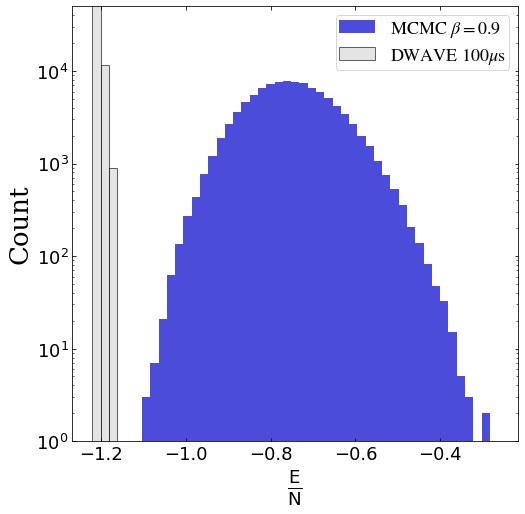

In [4]:
#path=["data/datasets/484-1nn-10mu/DWAVE-test-484spins-10mu.npy", "data/datasets/484-1nn-50mu/DWAVE-test-484spins-50mu.npy", "data/datasets/484-1nn-100mu/DWAVE-test-484spins-1nn-100mu.npy"]  #["/home/beppe/neural-mcmc/sample-100000_size-484_2021-11-15_14_31_46.npz"]

path = ["100spins-seed12345-sample100000-beta0.5.npy",]
labels = [r"MCMC $\beta=0.9$", r"MCMC $\beta=2.2$", r"NN Re-Weighted",]
truth = "data/datasets/seq_temp/100spins_open-1nn/dataset-beta2.0.npy" #/home/beppe/neural-mcmc/data/datasets/484-1nn-100mu/DWAVE-train-484spins-1nn-100mu.npy"
engs, eng_truth = plot_hist(path, couplings_path="data/couplings/100spins_open-1nn.txt" , truth_path=truth, labels=labels, save=True)

No sample subdir found in 484spins-seed12345-sample100000-beta0.2.npy 
Loading from path...

eng 0
mean: -0.004874215851072024
min: -0.1182368862584712 (1 time(s))

DWave data eng
mean: -0.004598514718438482
min: -0.09211391494979336  (28 time(s))


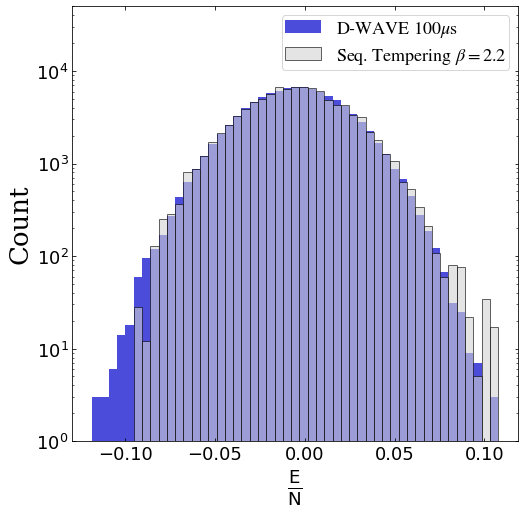

In [4]:
#path = glob.glob(f'100spins-single-beta2.0-long/*.npy')
#print(path)
path = ["sample-100000_size-484_2021-12-20_16:51:06.npz"]
labels = [r"D-WAVE 100$\mu$s", r"Neural MCMC $\beta=2.2$", r"Neural MCMC 10$\mu$s", r"Dwave 100$\mu$s", r"NN Re-Weighted",]
truth = "484spins-seed12345-sample100000-beta0.2.npy" #"/home/beppe/neural-mcmc/data/datasets/484-1nn-100mu/DWAVE-train-484spins-1nn-100mu.npy"
engs, eng_truth = plot_hist(path, couplings_path="data/couplings/100spins_open-1nn.txt", truth_path=truth, labels=labels, save=True)


## Results with Trained MADE on DWave Data

Computing the acceptance rate for some $\beta \in (0,5)$ we can notice that it exists an effective $\beta$, let's call it $\beta_{eff}$ that is increasing according to the annealing time selected in the D-Wave machine. 

In [14]:
datasets = ["data/generated/sample-200000_size-100_2021-12-09_15_06_01-1mus.npz", "data/generated/sample-200000_size-100_2021-12-09_16_54_16-10mus.npz", "data/generated/sample-200000_size-100_2021-12-09_09_41_24-100mus.npz"]
            #"size-10_sample-100001_nade.npz",
            #"size-100_sample-100001_1p8bmv7t.npz",]
betas = np.arange(0.1, 5., step=0.1)
couplings="data/couplings/100spins_open-1nn.txt"

In [ ]:
acc_rates = []
for dataset in tqdm(datasets, leave=True):
    acc_rate = []
    for beta in betas:
        _, _, ar = neural_mcmc(beta, 50000, dataset, couplings, "made", )
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

In [68]:
np.save("acc_rates", np.asarray(acc_rates))

### Energy versus steps

/tmp/ipykernel_20876/757092954.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,1000000)


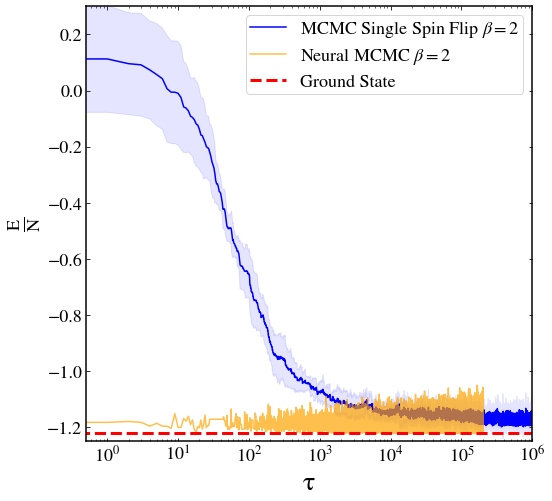

In [21]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

#ax.set_xticklabels([r'0', r'1', r'2',r'3',r'4',r'5',r'6'], fontsize=12, fontfamily=stringfont)
#ax.set_yticklabels([r'0',r'5',r'10',r'15',r'20',r'25', r'30',r'35'], fontsize=12, fontfamily=stringfont)

labels = [r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"]


plt.fill_between(np.arange(np.asarray(engs).shape[1]), np.asarray(engs).mean(axis=0) + np.asarray(engs).std(axis=0, ddof=1), np.asarray(engs).mean(axis=0) - np.asarray(engs).std(axis=0, ddof=1),  alpha=0.1, color="b")
plt.plot(np.asarray(engs).mean(axis=0), label=r"MCMC Single Spin Flip $\beta=2$", color="b", linewidth=1.5)
plt.plot(eng_truth, label=r"Neural MCMC $\beta=2$", color='orange', alpha=0.7)

ax.set_xscale("log")

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(which='both', top=True, right=True, direction='in')

plt.hlines(-1.2210371388, xmin=0, xmax=1000000, colors='red', linestyles='dashed', label="Ground State", linewidth=3.)

plt.xlim(0,1000000)
plt.ylim(-1.25,0.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\tau}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("anergy-vs-steps-smartbeta2.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [88]:
np.asarray(engs).mean(axis=0).shape

(200000,)

### Acceptance ratio versus Beta

/tmp/ipykernel_251/1619718679.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'0', r'1', r'2',r'3',r'4',r'5',r'6'], fontsize=16, fontfamily=stringfont)
/tmp/ipykernel_251/1619718679.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([r'0',r'5',r'10',r'15',r'20',r'25', r'30',r'35'], fontsize=16, fontfamily=stringfont)


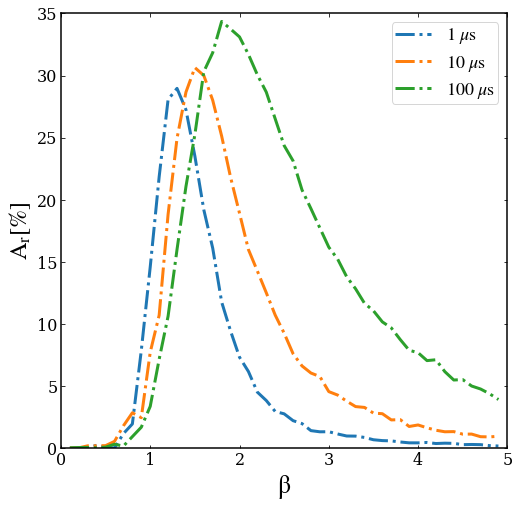

In [118]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)

ax.set_xticklabels([r'0', r'1', r'2',r'3',r'4',r'5',r'6'], fontsize=16, fontfamily=stringfont)
ax.set_yticklabels([r'0',r'5',r'10',r'15',r'20',r'25', r'30',r'35'], fontsize=16, fontfamily=stringfont)
ax.tick_params(which='both', top=True, right=True, direction='in')

labels = [r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"]

for i, acc_rate in enumerate(acc_rates):
    plt.plot(betas, acc_rate, "-.", label=labels[i], linewidth=3.)

plt.xlim(0,5)
plt.ylim(0,35)

plt.ylabel(r"$\mathrm{A_r}[\%]$", fontsize=24, fontfamily=stringfont)
plt.xlabel(r"$\mathrm{\beta}$", fontsize=26, fontfamily=stringfont)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("ar-vs-beta.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

### Mean and std for data

Here we compute the block mean and std to plot error bars.

In [12]:
def block_std(engs: List[np.ndarray], len_block: int, skip: int = 0):
    std_engs = []
    for eng in engs:
        eng = eng[skip:].copy()
        rest_len = eng.size % len_block
        if rest_len != 0:
            eng = eng[:-rest_len]
        eng = eng.reshape(-1, len_block)
        new_len = eng.shape[0]
        error = np.std(eng.mean(axis=1), ddof=0)/np.sqrt(new_len-1)
        std_engs.append(error)
    return std_engs

def block_mean(engs: List[np.ndarray], len_block: int, skip: int = 0):
    mean_engs = []
    for eng in engs:
        eng = eng[skip:].copy()
        rest_len = eng.size % len_block
        if rest_len != 0:
            eng = eng[:-rest_len]
        eng = eng.reshape(len_block, -1)
        mean_engs.append(np.mean(eng.mean(axis=0)))
    return mean_engs

0.00012961950149641073 0.0049934468279512366 0.004095620310081329


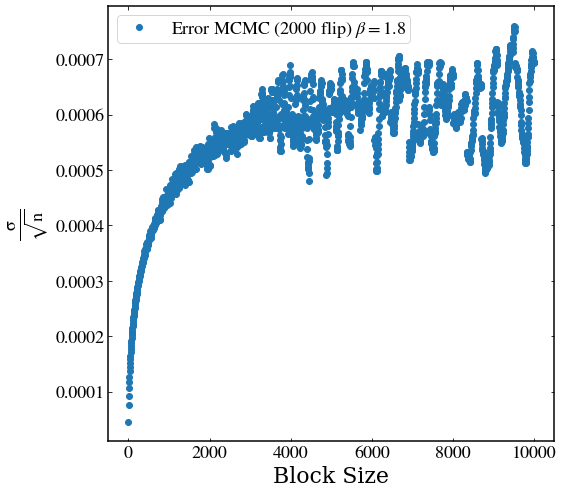

In [65]:

len_blocks = range(1, 10000, 5) #[2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 100, 200, 500, 1000, 5000, 10000]
block_stds = []
block_means = []
for len_block in len_blocks:
    block_stds.append(block_std(engs, len_block, skip=0))
    block_means.append(block_mean(engs, len_block, skip=0))
block_stds = np.asarray(block_stds)
block_means = np.asarray(block_means)


#blocks = [2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 100, 1000, 10000, 20000, 40000]
truth_std = []
truth_mean = []
for len_block in len_blocks:
    truth_std.append(block_std([eng_truth], len_block))
    truth_mean.append(block_mean([eng_truth], len_block))
truth_std = np.asarray(truth_std)
truth_mean = np.asarray(truth_mean)



fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5


stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.plot(np.arange(1, 10000, 5), block_stds[:,-3], "o", label=r"Error MCMC (2000 flip) $\beta=1.8$")
#plt.ylim(0,0.0001)

plt.ylabel(r"$\mathrm{\frac{\sigma}{\sqrt{n}}}$", fontsize=26, fontfamily=stringfont)
plt.xlabel(r"Block Size", fontsize=22, fontfamily=stringfont)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("std-vs-blocksize_beta1_8.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [16]:
def get_energy(square_spin: int, paths: List[str], couplings_path: str):
    adjacency = Adjacency(square_spin)
    adjacency.loadtxt(couplings_path)
    # get neighbourhood and couplings matrix
    neighbours, couplings = adjacency.get_neighbours()
    neighbours = neighbours.astype(int)
    len_neighbours = np.sum(couplings != 0, axis=-1)

    engs=[]
    for path in paths:
        out = np.load(path)

        try:
            sample = out["sample"]
        except:
            print(f"No sample subdir found in {path} \nLoading from path...")
            sample = out
        
        sample = sample.squeeze()
        sample = np.reshape(sample, (-1, square_spin, square_spin), order='F')
        sample = np.reshape(sample, (-1, square_spin**2), order='F')
        #sample = np.reshape(sample, (-1, square_spin, square_spin), order='F')

        eng = []
        for s in sample:
            eng.append(compute_energy(s, neighbours, couplings, len_neighbours))
        eng = np.asarray(eng) / square_spin**2

        engs.append(eng)
    return engs

### Neural MCMC vs MCMC (2000 flips)

In [17]:
couplings_path="data/couplings/100spins_open-1nn.txt"

mu100_paths = ["temp-data/100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199997steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199997steps.npz", 
    "temp-data/100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199997steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199997steps.npz", 
    "temp-data/100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199997steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199997steps.npz", 
    "temp-data/100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199997steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199997steps.npz",
    ]
mu10_paths = ["temp-data/100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199998steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199998steps.npz", 
    "temp-data/100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199998steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199998steps.npz", 
     "temp-data/100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199998steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199998steps.npz", 
     "temp-data/100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199998steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199998steps.npz"]
mu1_paths = ["temp-data/100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199999steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199999steps.npz", 
    "temp-data/100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199999steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199999steps.npz", 
     "temp-data/100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199999steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199999steps.npz", 
     "temp-data/100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199999steps.npz", "temp-data/100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199999steps.npz"]
single_spin = ["temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy", "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.0.npy", 
    "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.2.npy", "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.4.npy", 
    "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.6.npy", "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.8.npy",
    "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta2.0.npy", "temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta2.2.npy"]

eng_1mu = get_energy(10, mu1_paths, couplings_path)
eng_10mu = get_energy(10, mu10_paths, couplings_path)
eng_100mu = get_energy(10, mu100_paths, couplings_path)
eng_single = get_energy(10, single_spin, couplings_path)

No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.0.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.2.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.4.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.6.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta1.8.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta2.0.npy 
Loading from path...
No sample subdir found in temp-data/100spins-open1nn-single/100spins-seed12345-sample200000-beta2.2.npy 
Loading from 

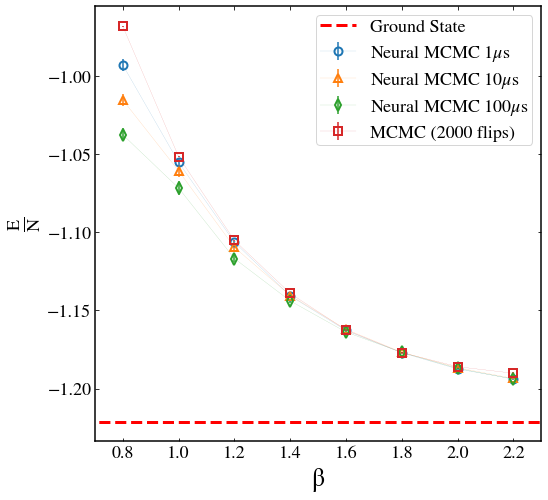

In [76]:
fig, ax =  plt.subplots(figsize=(8.6, 8.6),  facecolor='white', dpi=300)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, direction='in', labelsize=24)
plt.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, direction='in', labelsize=24)

plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_1mu, 2000), yerr=block_std(eng_1mu, 2000), elinewidth=1.5, linewidth=.1, marker='o', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $1\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_10mu, 2000), yerr=block_std(eng_10mu, 2000), elinewidth=1.5, linewidth=.1, marker='^', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $10\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_100mu, 2000), yerr=block_std(eng_100mu, 2000), elinewidth=1.5, linewidth=.1, marker='d', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $100\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_single, 3000, skip=800), yerr=block_std(eng_single, 3000, skip=1000), elinewidth=1.5, linewidth=.1, marker='s', fillstyle='none', markersize=8, markeredgewidth=2, label=r"MCMC (2000 flips)")

plt.hlines(-1.2210371388, xmin=0.6, xmax=2.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.7, 2.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("energy_neural-vs-mcmc.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')


### Neural MCMC vs Sequential Tempering

In [163]:
couplings_path="data/couplings/100spins_open-1nn.txt"

mu100_paths = ["100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199997steps.npz",
    ]
mu10_paths = ["100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199998steps.npz", "100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199998steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199998steps.npz", "100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199998steps.npz", 
     "100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199998steps.npz", "100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199998steps.npz", 
     "100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199998steps.npz", "100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199998steps.npz"]
mu1_paths = ["100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199999steps.npz", "100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199999steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199999steps.npz", "100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199999steps.npz", 
     "100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199999steps.npz", "100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199999steps.npz", 
     "100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199999steps.npz", "100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199999steps.npz"]
seq_tempering = ["100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy", "100spins-open1nn-seqtemper/100spins_beta1.0_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.2_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.4_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.6_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.8_neural-mcmc_200000steps.npz",
    "100spins-open1nn-seqtemper/100spins_beta2.0_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta2.2_neural-mcmc_200000steps.npz"]

eng_1mu = get_energy(10, mu1_paths, couplings_path)
eng_10mu = get_energy(10, mu10_paths, couplings_path)
eng_100mu = get_energy(10, mu100_paths, couplings_path)
eng_tempering = get_energy(10, seq_tempering, couplings_path)

No sample subdir found in 100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy 
Loading from path...


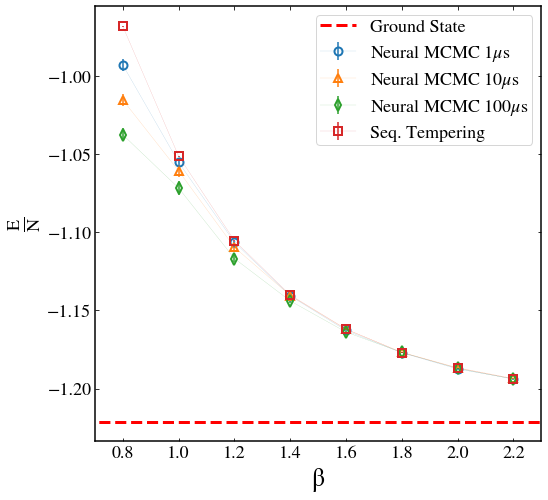

In [164]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_1mu, 2000), yerr=block_std(eng_1mu, 2000), elinewidth=1.5, linewidth=.1, marker='o', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $1\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_10mu, 2000), yerr=block_std(eng_10mu, 2000), elinewidth=1.5, linewidth=.1, marker='^', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $10\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_100mu, 2000), yerr=block_std(eng_100mu, 2000), elinewidth=1.5, linewidth=.1, marker='d', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $100\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_tempering, 2000), yerr=block_std(eng_tempering, 2000), elinewidth=1.5, linewidth=.1, marker='s', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Seq. Tempering")

plt.hlines(-1.2210371388, xmin=0.6, xmax=2.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.7, 2.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)


plt.savefig("energy_neural-vs-tempering.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

### Smart MCMC vs Sequential Tempering

In [7]:
couplings_path="data/couplings/100spins_open-1nn.txt"

smart100_paths = ["100spins-smartMCMC-new/100spins_beta0.8_smart-mcmc100m.npz", "100spins-smartMCMC-new/100spins_beta1.0_smart-mcmc100m.npz",
    "100spins-smartMCMC-new/100spins_beta1.2_smart-mcmc100m.npz", "100spins-smartMCMC-new/100spins_beta1.4_smart-mcmc100m.npz", 
    "100spins-smartMCMC-new/100spins_beta1.6_smart-mcmc100m.npz", "100spins-smartMCMC-new/100spins_beta1.8_smart-mcmc100m.npz",
    "100spins-smartMCMC-new/100spins_beta2.0_smart-mcmc100m.npz", "100spins-smartMCMC-new/100spins_beta2.2_smart-mcmc100m.npz",  
    ]
smart10_paths = ["100spins-smartMCMC-new/100spins_beta0.8_smart-mcmc-10m.npz", "100spins-smartMCMC-new/100spins_beta1.0_smart-mcmc-10m.npz",
    "100spins-smartMCMC-new/100spins_beta1.2_smart-mcmc-10m.npz", "100spins-smartMCMC-new/100spins_beta1.4_smart-mcmc-10m.npz",
    "100spins-smartMCMC-new/100spins_beta1.6_smart-mcmc-10m.npz", "100spins-smartMCMC-new/100spins_beta1.8_smart-mcmc-10m.npz",
    "100spins-smartMCMC-new/100spins_beta2.0_smart-mcmc-10m.npz", "100spins-smartMCMC-new/100spins_beta2.2_smart-mcmc-10m.npz"]
smart1_paths = ["100spins-smartMCMC-new/100spins_beta0.8_smart-mcmc1-1m.npz", "100spins-smartMCMC-new/100spins_beta1.0_smart-mcmc1-1m.npz",
    "100spins-smartMCMC-new/100spins_beta1.2_smart-mcmc1-1m.npz", "100spins-smartMCMC-new/100spins_beta1.4_smart-mcmc1-1m.npz", 
    "100spins-smartMCMC-new/100spins_beta1.6_smart-mcmc1-1m.npz", "100spins-smartMCMC-new/100spins_beta1.8_smart-mcmc1-1m.npz",
    "100spins-smartMCMC-new/100spins_beta2.0_smart-mcmc1-1m.npz", "100spins-smartMCMC-new/100spins_beta2.2_smart-mcmc1-1m.npz"]
seq_tempering = ["100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy", "100spins-open1nn-seqtemper/100spins_beta1.0_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.2_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.4_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.6_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.8_neural-mcmc_200000steps.npz",
    "100spins-open1nn-seqtemper/100spins_beta2.0_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta2.2_neural-mcmc_200000steps.npz"]
    

eng_smart1mu = get_energy(10, smart1_paths, couplings_path)
eng_smart10mu = get_energy(10, smart10_paths, couplings_path)
eng_smart100mu = get_energy(10, smart100_paths, couplings_path)
eng_tempering = get_energy(10, seq_tempering, couplings_path)

NameError: name 'get_energy' is not defined

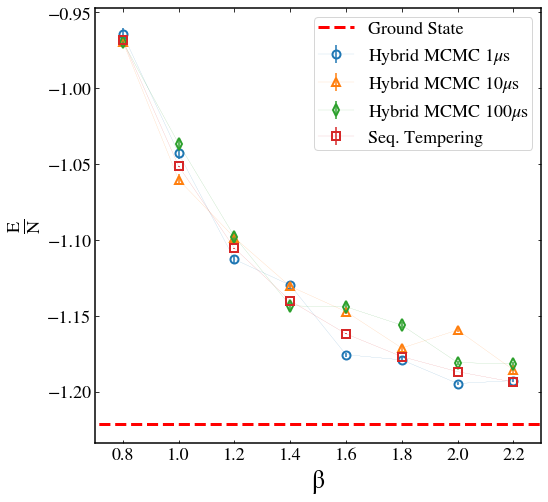

In [166]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_smart1mu, 5000, skip=1000), yerr=block_std(eng_smart1mu, 5000, skip=1000), elinewidth=1.5, linewidth=.1, marker='o', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Hybrid MCMC $1\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_smart10mu, 5000, skip=1000), yerr=block_std(eng_smart10mu, 5000, skip=1000), elinewidth=1.5, linewidth=.1, marker='^', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Hybrid MCMC $10\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_smart100mu, 5000, skip=1000), yerr=block_std(eng_smart100mu, 5000, skip=1000), elinewidth=1.5, linewidth=.1, marker='d', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Hybrid MCMC $100\mu$s")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_tempering, 2000), yerr=block_std(eng_tempering, 2000), elinewidth=1.5, linewidth=.1, marker='s', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Seq. Tempering")

plt.hlines(-1.2210371388, xmin=0.6, xmax=2.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.7, 2.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("energy_smart_new-vs-mcmc.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

### Smart MCMC vs Sequential Tempering (dataset $\beta=0.5$)

In [110]:
couplings_path="data/couplings/100spins_open-1nn.txt"

smart_beta05_path = ["100spins-smartMCMC-beta05-single/100spins_beta0.6_smart-mcmc:04:_single_prob0.5.npz", "100spins-smartMCMC-beta05-single/100spins_beta0.8_smart-mcmc:04:_single_prob0.5.npz",
    "100spins-smartMCMC-beta05-single/100spins_beta1.0_smart-mcmc:04:_single_prob0.5.npz", "100spins-smartMCMC-beta05-single/100spins_beta1.2_smart-mcmc:04:_single_prob0.5.npz", 
    "100spins-smartMCMC-beta05-single/100spins_beta1.4_smart-mcmc:04:_single_prob0.5.npz", "100spins-smartMCMC-beta05-single/100spins_beta1.6_smart-mcmc:04:_single_prob0.5.npz",
    "100spins-smartMCMC-beta05-single/100spins_beta1.8_smart-mcmc:04:_single_prob0.5.npz", "100spins-smartMCMC-beta05-single/100spins_beta2.0_smart-mcmc:04:_single_prob0.5.npz",
    "100spins-smartMCMC-beta05-single/100spins_beta2.2_smart-mcmc:04:_single_prob0.5.npz",]
seq_tempering = ["100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy", "100spins-open1nn-seqtemper/100spins_beta1.0_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.2_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.4_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.6_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.8_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta2.0_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta2.2_neural-mcmc_200000steps.npz",]
    

eng_beta05 = get_energy(10, smart_beta05_path, couplings_path)
eng_tempering = get_energy(10, seq_tempering, couplings_path)
print(len(eng_beta05), len(eng_tempering))

No sample subdir found in 100spins-seed12345-sample100000-beta0.5.npy 
Loading from path...
No sample subdir found in 100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy 
Loading from path...
9 9


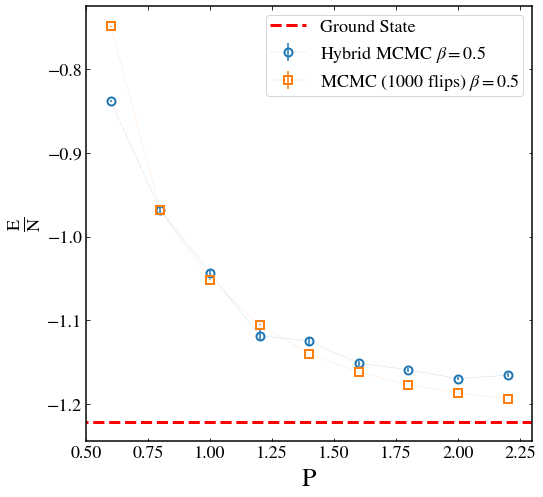

In [132]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.errorbar([0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_beta05, 5000, skip=1000), yerr=block_std(eng_beta05, 5000, skip=1000), elinewidth=1.5, linewidth=.1, marker='o', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Hybrid MCMC $\beta=0.5$")
plt.errorbar([0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_tempering, 2000), yerr=block_std(eng_tempering, 2000), elinewidth=1.5, linewidth=.1, marker='s', fillstyle='none', markersize=8, markeredgewidth=2, label=r"MCMC (1000 flips) $\beta=0.5$")


plt.hlines(-1.2210371388, xmin=0.4, xmax=2.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.5, 2.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{P}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("energy_hybrid_beta05-vs-mcmc.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

### Neural and Hybrid MCMC vs Seq. Tempering (Hybrid Dataset $100\mu s$ and $\beta=0.5$)

In [5]:
couplings_path="data/couplings/100spins_open-1nn.txt"

mu100_paths = ["100spins-neuralMCMC/100spins_beta0.8_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.0_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.2_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.4_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta1.6_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta1.8_neural-mcmc_199997steps.npz", 
    "100spins-neuralMCMC/100spins_beta2.0_neural-mcmc_199997steps.npz", "100spins-neuralMCMC/100spins_beta2.2_neural-mcmc_199997steps.npz",
    ]

hybrid100_05_paths = ["100spins-open1nn-hybrid-neuralMCMC/100spins_beta0.8_neural-mcmc_200000steps.npz", "100spins-open1nn-hybrid-neuralMCMC/100spins_beta1.0_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-hybrid-neuralMCMC/100spins_beta1.2_neural-mcmc_200000steps.npz", "100spins-open1nn-hybrid-neuralMCMC/100spins_beta1.4_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-hybrid-neuralMCMC/100spins_beta1.6_neural-mcmc_200000steps.npz", "100spins-open1nn-hybrid-neuralMCMC/100spins_beta1.8_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-hybrid-neuralMCMC/100spins_beta2.0_neural-mcmc_200000steps.npz", "100spins-open1nn-hybrid-neuralMCMC/100spins_beta2.2_neural-mcmc_200000steps.npz",
    ]

hybrid_hybrid100_05_paths = ["100spins-open1nn-hybrid-hybridMCMC/100spins_beta0.8_smart-mcmc:09:_single_prob0.5.npz", "100spins-open1nn-hybrid-hybridMCMC/100spins_beta1.0_smart-mcmc:09:_single_prob0.5.npz", 
    "100spins-open1nn-hybrid-hybridMCMC/100spins_beta1.2_smart-mcmc:09:_single_prob0.5.npz", "100spins-open1nn-hybrid-hybridMCMC/100spins_beta1.4_smart-mcmc:09:_single_prob0.5.npz", 
    "100spins-open1nn-hybrid-hybridMCMC/100spins_beta1.6_smart-mcmc:09:_single_prob0.5.npz", "100spins-open1nn-hybrid-hybridMCMC/100spins_beta1.8_smart-mcmc:09:_single_prob0.5.npz", 
    "100spins-open1nn-hybrid-hybridMCMC/100spins_beta2.0_smart-mcmc:09:_single_prob0.5.npz", "100spins-open1nn-hybrid-hybridMCMC/100spins_beta2.2_smart-mcmc:09:_single_prob0.5.npz",
    ]

seq_tempering = ["100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy", "100spins-open1nn-seqtemper/100spins_beta1.0_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.2_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.4_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta1.6_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta1.8_neural-mcmc_200000steps.npz", 
    "100spins-open1nn-seqtemper/100spins_beta2.0_neural-mcmc_200000steps.npz", "100spins-open1nn-seqtemper/100spins_beta2.2_neural-mcmc_200000steps.npz",]

eng_mu100 = get_energy(10, mu100_paths, couplings_path)
eng_hybrid100_05 = get_energy(10, hybrid100_05_paths, couplings_path)
eng_hybrid_hybrid100_05 = get_energy(10, hybrid_hybrid100_05_paths, couplings_path)
eng_tempering = get_energy(10, seq_tempering, couplings_path)

No sample subdir found in 100spins-open1nn-single/100spins-seed12345-sample200000-beta0.8.npy 
Loading from path...


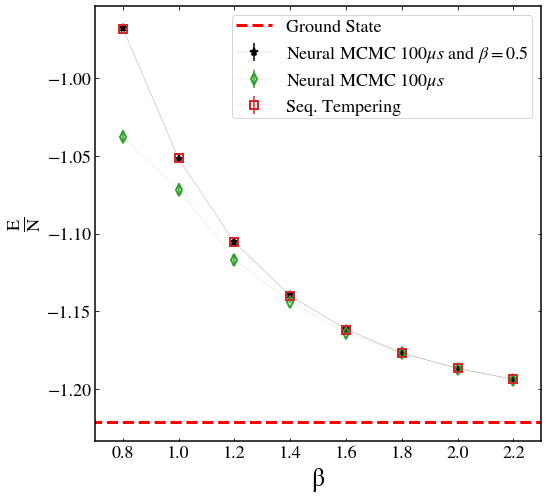

In [8]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5

stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_hybrid100_05, 2000), yerr=block_std(eng_hybrid100_05, 2000), elinewidth=1.5, linewidth=.1, marker='*', color='black', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $100 \mu s$ and $\beta=0.5$")
#plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_hybrid_hybrid100_05, 2000), yerr=block_std(eng_hybrid_hybrid100_05, 2000), elinewidth=1.5, linewidth=.1, marker='x', color='tab:blue', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Hybrid MCMC $100 \mu s$ and $\beta=0.5$")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_mu100, 2000), yerr=block_std(eng_mu100, 2000), elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC $100 \mu s$")
plt.errorbar([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2., 2.2], block_mean(eng_tempering, 2000), yerr=block_std(eng_tempering, 2000), elinewidth=1.5, linewidth=.1, marker='s', color='tab:red', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Seq. Tempering")


plt.hlines(-1.2210371388, xmin=0.4, xmax=2.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.7, 2.3)

plt.ylabel(r"$\mathrm{\frac{E}{N}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=26, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("energy_hybrid_100mu_beta05-vs-seq_tempering.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [14]:
len_blocks = range(1, 10000, 5) #[2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 100, 200, 500, 1000, 5000, 10000]
block_stds = []
block_means = []
for len_block in len_blocks:
    block_stds.append(block_std(eng_mu100, len_block, skip=0))
    block_means.append(block_mean(eng_mu100, len_block, skip=0))
block_stds = np.asarray(block_stds)
block_means = np.asarray(block_means)

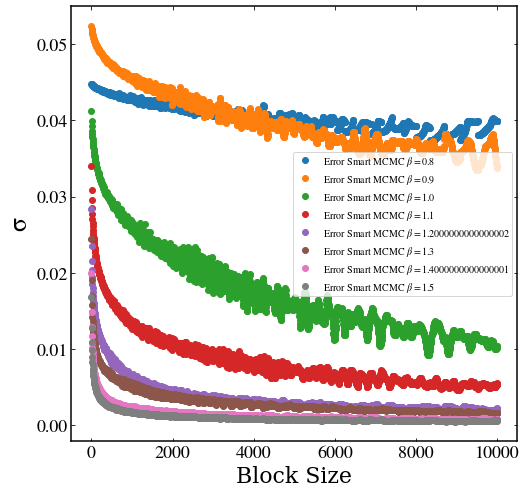

In [15]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5


stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

for i in range(block_stds.shape[1]):
    plt.plot(np.arange(1, 10000, 5), block_stds[:,i], "o", label=r"Error Smart MCMC $\beta="f"${0.8+0.1*i}")
#plt.ylim(0,0.0001)

plt.ylabel(r"$\mathrm{\sigma}$", fontsize=26, fontfamily=stringfont)
plt.xlabel(r"Block Size", fontsize=22, fontfamily=stringfont)

plt.legend(loc='best', labelspacing=0.4, borderpad=0.2)

#plt.savefig("std-vs-blocksize_beta1_8.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [9]:
strenghts = np.linspace(0.5, 4, 15)

engs = []
for strenght in strenghts:
    engs.append(np.load(f"data/sweep_chain_strength/dwave-engs_{strenght}.npy"))
engs = np.asarray(engs)

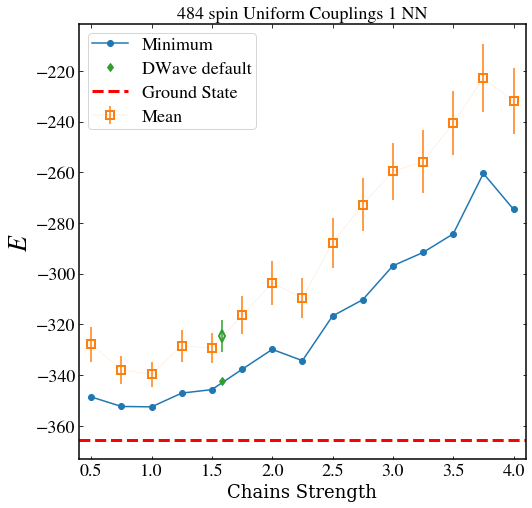

In [10]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5


stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.plot(strenghts, engs.min(1), "-o", label=r"Minimum")
plt.plot(1.5828847157168355, np.load("data/sweep_chain_strength/dwave-engs_0.npy").min(), "d", color='tab:green', label=f"DWave default")
plt.errorbar(1.5828847157168355, np.load("data/sweep_chain_strength/dwave-engs_0.npy").mean(), np.load("data/sweep_chain_strength/dwave-engs_0.npy").std(), elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2)
plt.errorbar(strenghts, engs.mean(1), engs.std(1), elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

plt.hlines(-365.434418602, xmin=0, xmax=4.5, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.4, 4.1)

plt.ylabel(r"$E$", fontsize=26, fontfamily=stringfont)
plt.xlabel(r"Chains Strength", fontsize=18, fontfamily=stringfont)

plt.title("484 spin Uniform Couplings 1 NN",  fontsize=18)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("strenght-energy_uniform.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')


In [76]:
strenghts = np.linspace(1.25, 5, 16)

engs = []
for strenght in strenghts:
    engs.append(np.load(f"sweep_chains_gaussian/dwave-engs_{strenght}.npy"))
engs = np.asarray(engs)

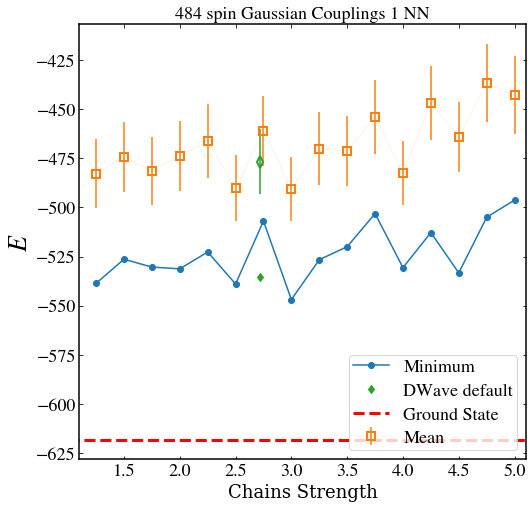

In [77]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5


stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.plot(strenghts, engs.min(1), "-o", label=r"Minimum")
plt.plot(2.7174204926999237, np.load("sweep_chains_gaussian/dwave-engs_0.npy").min(), "d", color='tab:green', label=f"DWave default")
plt.errorbar(2.7174204926999237, np.load("sweep_chains_gaussian/dwave-engs_0.npy").mean(), np.load("sweep_chains_gaussian/dwave-engs_0.npy").std(), elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2)
plt.errorbar(strenghts, engs.mean(1), engs.std(1), elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

plt.hlines(-618.023412952, xmin=1, xmax=5.5, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(1.1, 5.1)

plt.ylabel(r"$E$", fontsize=26, fontfamily=stringfont)
plt.xlabel(r"Chains Strength", fontsize=18, fontfamily=stringfont)

plt.title("484 spin Gaussian Couplings 1 NN",  fontsize=18)

plt.legend(loc='lower right', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("strenght-energy_gaussian.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [3]:
strenghts = np.linspace(0.25, 5, 20)

engs = []
for strenght in strenghts:
    engs.append(np.load(f"data/sweep_chains_binary/dwave-engs_{strenght}.npy"))
engs = np.asarray(engs)

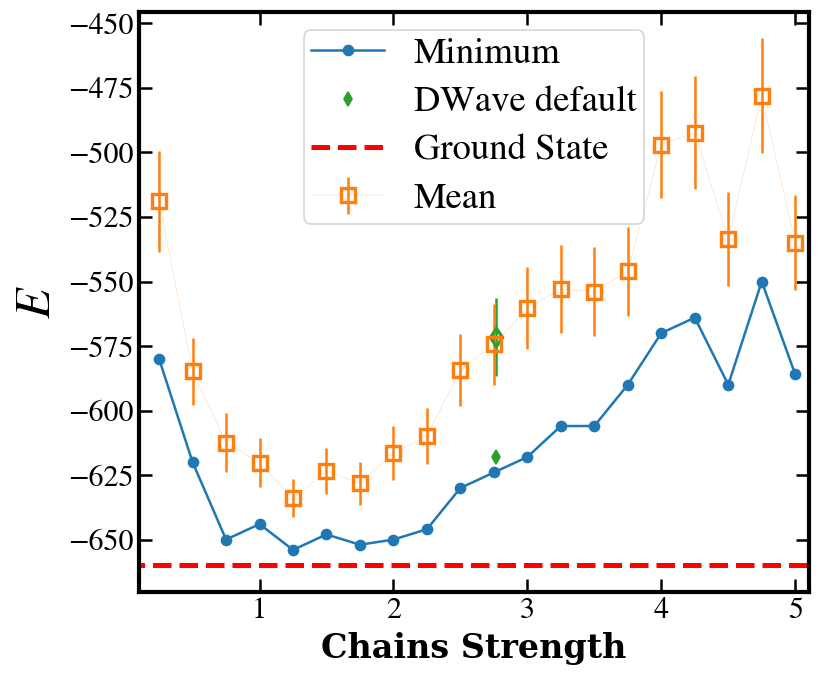

In [9]:
fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120,)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)


plt.plot(strenghts, engs.min(1), "-o", label=r"Minimum")
plt.plot(2.7629798143572195, np.load("data/sweep_chains_binary/dwave-engs_0.npy").min(), "d", color='tab:green', label=f"DWave default")
plt.errorbar(2.7629798143572195, np.load("data/sweep_chains_binary/dwave-engs_0.npy").mean(), np.load("data/sweep_chains_binary/dwave-engs_0.npy").std(), elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2)
plt.errorbar(strenghts, engs.mean(1), engs.std(1), elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

plt.hlines(-659.999, xmin=0, xmax=5.5, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.1, 5.1)

plt.ylabel(r"$E$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"Chains Strength", fontsize=20, fontfamily=stringfont, fontweight='bold')

plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)

plt.savefig("images/energy-block.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True)

In [6]:
import numpy as np
from src.utils.utils import get_couplings, compute_energy
from src.utils.montecarlo import single_spin_flip

neighbours, couplings, len_neighbours = get_couplings(3, "9spins-uniform-3nn.txt")

sample = - np.ones(9)
upspin_idx = np.asarray([6, 7, 8]) - 1 
sample[upspin_idx] = 1
print(sample)

compute_energy(sample, neighbours, couplings, len_neighbours)

[-1. -1. -1. -1. -1.  1.  1.  1. -1.]


5.722511296300001

In [3]:
strenghts = np.linspace(0.25, 4, 16)

engs = []
for strenght in strenghts:
    engs.append(np.load(f"484spins-uniform-3nn-1mus/dwave-engs_{strenght}.npy"))
engs = np.asarray(engs)

In [11]:
print(engs.shape)

(16, 1000)


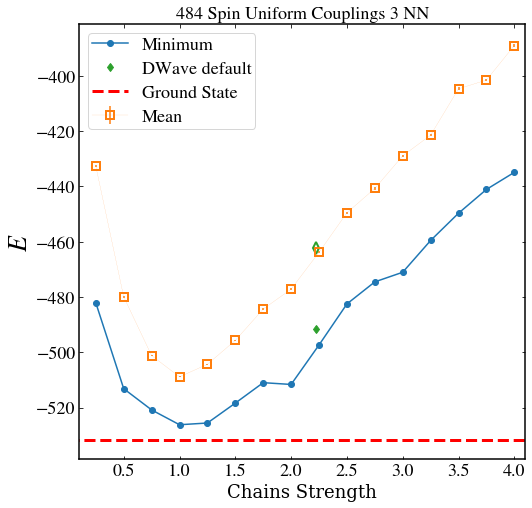

In [13]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 1.5


stringfont = 'serif'

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')
plt.tick_params(top=True, right=True, labeltop=False, labelright=False, direction='in')

plt.plot(strenghts, engs.min(1), "-o", label=r"Minimum")
plt.plot(2.2228021968, np.load("484spins-uniform-3nn-1mus/dwave-engs_0.npy").min(), "d", color='tab:green', label=f"DWave default")
plt.errorbar(2.2228021968, np.load("484spins-uniform-3nn-1mus/dwave-engs_0.npy").mean(), np.load("484spins-uniform-3nn-1mus/dwave-engs_0.npy").std() / np.sqrt(engs.shape[-1] - 1), elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2)
plt.errorbar(strenghts, engs.mean(axis=1), engs.std(axis=1) / np.sqrt(engs.shape[-1] - 1), elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

plt.hlines(-531.5252, xmin=0, xmax=5.5, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.1, 4.1)

plt.ylabel(r"$E$", fontsize=26, fontfamily=stringfont)
plt.xlabel(r"Chains Strength", fontsize=18, fontfamily=stringfont)

plt.title("484 Spin Uniform Couplings 3 NN",  fontsize=18)

plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("strenght-energy_binary.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')